In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.arima import ARIMA
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
import statsmodels.api as sm
import statsmodels.tsa.api as smt
warnings.filterwarnings('ignore')
warnings.simplefilter("ignore", ConvergenceWarning)

In [2]:
def tsplot(y, lags=None, figsize=(12, 7)):
    """
        Plot time series, its ACF and PACF, calculate Dickey–Fuller test
        
        y - timeseries
        lags - how many lags to include in ACF, PACF calculation
    """
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
           
    fig = plt.figure(figsize=figsize)
    layout = (2, 2)
    ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
    acf_ax = plt.subplot2grid(layout, (1, 0))
    pacf_ax = plt.subplot2grid(layout, (1, 1))

    y.plot(ax=ts_ax)
    p_value = sm.tsa.stattools.adfuller(y)[1]
    ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
    smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
    smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
    plt.tight_layout()

In [3]:
# Read the CSV file into a DataFrame
df = pd.read_csv('AirtrafficA4.csv')

df['PASSENGERS CARRIED'] = df['PASSENGERS CARRIED'].str.replace(',', '').astype(float)
df.fillna(1, inplace=True)


# create column for year_month
d = {'JAN': '01', 'FEB': '02', 'MAR': '03', 'APR': '04', 'MAY': '05', 'JUNE': '06', 'JULY': '07', 'AUG': '08', 'SEP': '09', 'OCT': '10', 'NOV': '11', 'DEC': '12'}
df['MONTH'] = df['MONTH'].str.replace(' ', '')
df['year_month'] = df['YEAR'].astype(str) + "-" + df['MONTH'].map(d).astype(str)
df['year_month'] = pd.to_datetime(df['year_month'], format='%Y-%m')
df['year_month_period'] = df['year_month'].dt.to_period("M")

# sort values by time, reset the indices
df.sort_values(by=['year_month'], inplace=True)
df.reset_index(inplace=True)

# create a column for logs of values
df['log_pass'] = np.log(df['PASSENGERS CARRIED'])

# df.head(50)

In [4]:
# Prepare the data and forecasting horizon
y = df.set_index('year_month_period')['PASSENGERS CARRIED']
fh = ForecastingHorizon(
    pd.PeriodIndex(pd.date_range("2023-09", periods=12, freq="ME")), is_relative=False
)

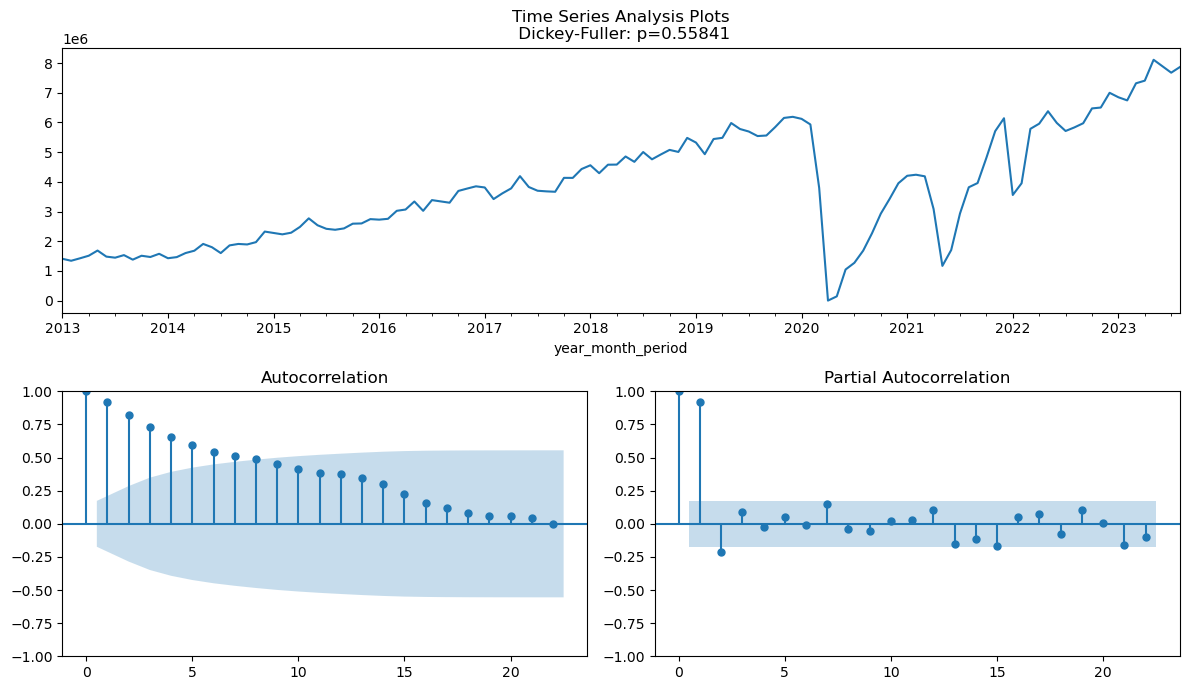

In [5]:
tsplot(y)

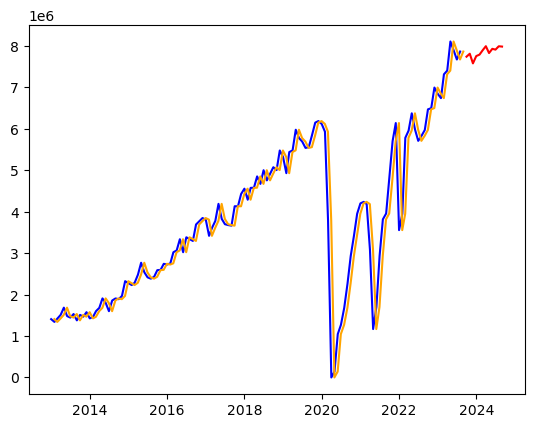

In [6]:
# Fit the ARIMA model
forecaster = ARIMA(order=(10, 1, 10))
forecaster.fit(y)
prediction = forecaster.predict(fh)

plt.plot(df['year_month'], df['PASSENGERS CARRIED'], color='blue')
plt.plot(prediction, color='red')
plt.plot(y, color='orange')
plt.savefig('ARIMA.png')
plt.show()

In [7]:
periods = ['2023 SEP', '2023 OCT', '2023 NOV', '2023 DEC', '2024 JAN', '2024 FEB', '2024 MAR', '2024 APR', '2024 MAY', '2024 JUN', '2024 JUL', '2024 AUG']
df_prediction = pd.DataFrame({
    'YEAR_MONTH' : periods,
    'PASSENGERS CARRIED' : prediction.tail(12).values
    })
df_prediction.to_csv('submission.csv', index=False) 